# Dog.. pig.. dog.. pig.. loaf of bread?!?

I started playing with image recognition models recently and it started off very well.  The models I trained were able to easily (and confidently!) identify common pets or objects.  But what about something harder?  I wanted to see it break down so I could see what more training iterations or a large data set would do.  How can I do that easily?

It struck me.  I call it a moment of inspiration.  You might call it lunacy.  Either way, I was amused with the though.

Have you see the movie "The Mitchells vs The Machines"?  The dog Monchi is a pug and for whatever reason causes the dumber robots to explode because they can't figure out if he's a pig, dog, or loaf of bread.  Would this really confuse an AI?

In this blog I will walk through:
* The creation of a Red Hat OpenShift on AWS (ROSA) with Hosted Control Planes (HCP) cluster.
* Installation of Red Hat OpenShift Data Science.
* Creation of a Data Science Project and Workspace.
* Walking through the steps to download image data, train a model, and test if it works.
* And if it doesn't go well for the machines... change things to see if we can get a better result.

The notebook in this blog is based on the excellent [Practical Deep Learning for Coders](https://course.fast.ai/).

Let's get started!

## Create a ROSA HCP Cluster

Follow the documentation on creating a [ROSA with HCP](https://docs.openshift.com/rosa/rosa_hcp/rosa-hcp-sts-creating-a-cluster-quickly.html) cluster.  It is a premier OpenShift cluster supported by Red Hat SRE and is reasonably priced.  

Provision with three (3) `m5.xlarge` workers to make sure the workspace can be deployed successfully.


### Optional: GPU Instance
If you wish to use a GPU, which makes training models much faster, you can:
1. change the instance type for the default workers to `t3.xlarge`
1. reduce worker replicas at creation time to two (2)
1. install one (1) `g5.xlarge` day-2 with:
```bash
rosa create machinepool --cluster=$CLUSTER_NAME --name=gpu --replicas=1 --instance-type=g5.xlarge
```

When setting up the data science workspace you can select "CUDA"!

## Install OpenShift AI
TODO
Looking at a [trial](https://www.redhat.com/en/technologies/cloud-computing/openshift/openshift-ai/trial) setup.

## Access Cluster
Simplest way is to [create an admin user](https://docs.openshift.com/rosa/cloud_experts_tutorials/cloud-experts-getting-started/cloud-experts-getting-started-admin.html).

```bash
rosa create admin --cluster=$CLUSTER_NAME
```

The output of the above command includes the `oc login` statment you can use to login.  This has the username and password you'll need later.

In [1]:
#hidden
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
!pip install -Uqq fastai duckduckgo_search

In [3]:
from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')    

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

def download_validation_image(term):
    urls = search_images(f"{term} photos", max_images=1)

    dest = f"validation_data/{term}.jpg"
    download_url(urls[0], dest, show_progress=False)

    im = Image.open(dest)
    return im.to_thumb(256,256)

Make it easier to swap out the model and see how things change by defining a variable to capture the model.

In [5]:
model=resnet34

In [6]:
import shutil

# start with a clean (empty) set of data
shutil.rmtree('training_data', ignore_errors=True)
shutil.rmtree('validation_data', ignore_errors=True)

Searching for 'pug face photos'


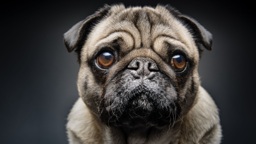

In [7]:
download_validation_image("pug face")

Searching for 'cute pug face photos'


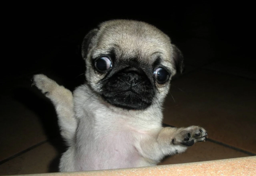

In [8]:
download_validation_image("cute pug face")

Searching for 'pug full body adult photos'


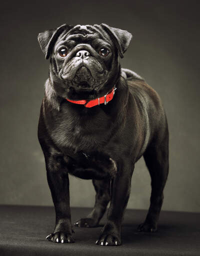

In [9]:
download_validation_image("pug full body adult")

Searching for 'pig photos'


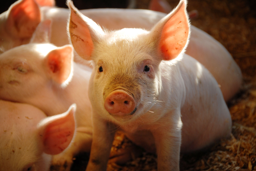

In [10]:
download_validation_image("pig")

Searching for 'bread photos'


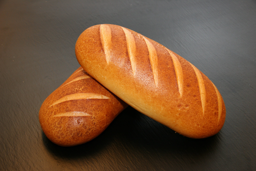

In [11]:
download_validation_image("bread")

In [12]:
searches = ['dog','pig','loaf of bread']
path = Path('training_data')
from time import sleep

max_images=5

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'"{o}" photo', max_images))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'"{o} in sun" photo', max_images))
    sleep(10)
    download_images(dest, urls=search_images(f'"{o} in shade" photo', max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for '"dog" photo'
Searching for '"dog in sun" photo'
Searching for '"dog in shade" photo'
Searching for '"pig" photo'
Searching for '"pig in sun" photo'
Searching for '"pig in shade" photo'
Searching for '"loaf of bread" photo'
Searching for '"loaf of bread in sun" photo'
Searching for '"loaf of bread in shade" photo'


In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

/opt/app-root/lib64/python3.9/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


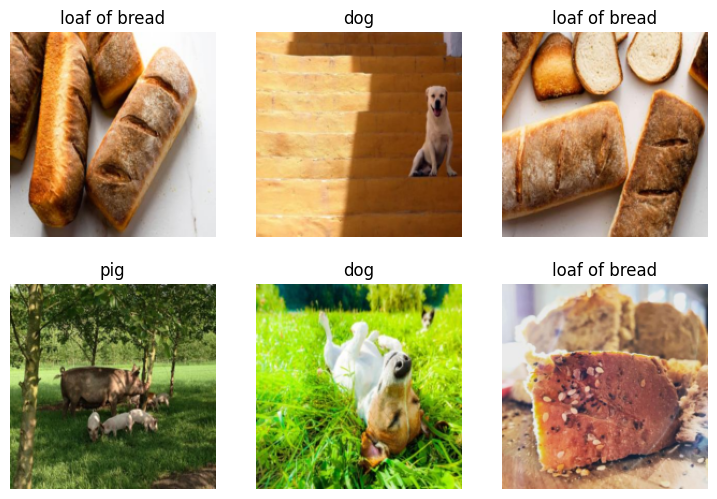

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [15]:
learn = vision_learner(dls, model, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.418758,1.211653,0.500000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.763593,0.599322,0.500000,00:03
1,1.504826,0.125533,0.000000,00:03
2,1.072297,0.051021,0.000000,00:03


In [16]:
def check_category(term):
    dest=f"validation_data/{term}.jpg"
    category,category_num,probs = learn.predict(PILImage.create(dest))
    print(f"This is a: {category}")
    print(f"Probability it's a {category}: {probs[category_num]:.4f}")
    im = Image.open(dest)
    return im.to_thumb(256,256)

This is a: pig
Probability it's a pig: 0.6109


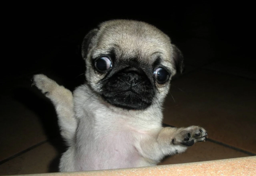

In [17]:
check_category("cute pug face")

This is a: loaf of bread
Probability it's a loaf of bread: 0.5263


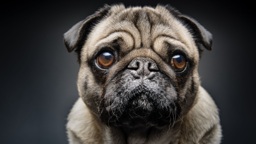

In [18]:
check_category("pug face")

This is a: pig
Probability it's a pig: 0.6529


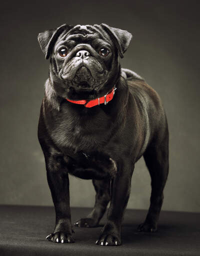

In [19]:
check_category("pug full body adult")

This is a: pig
Probability it's a pig: 0.9905


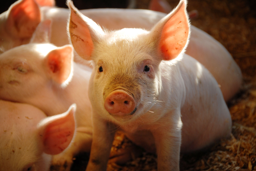

In [20]:
check_category("pig")

This is a: loaf of bread
Probability it's a loaf of bread: 0.9876


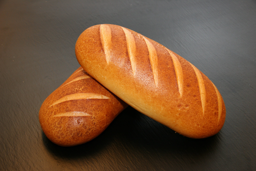

In [21]:
check_category("bread")

It's accurate enough it seems.  But if needed, can train with more epochs and/or more image data.

**NOTE**: if 'sun dog' is not a known category, it will be a hit for dog images.  I guess there's some 'sun dog' data getting into the data?

# Revision: sun dog
In playing around with this example I found when searching for "dog" there were images for "sun dogs" that show up in the result set.  A [sun dog](https://en.wikipedia.org/wiki/Sun_dog) is an atomospheric phenomenom that shows a halo with bright spots around the sun.  It's not common, worth looking out for in colder winter months!  But it's not a "dog" in the context of what we're doing here.

What happens if we try identifying a "sun dog" with our current categorization?

Searching for 'sun dog photos'


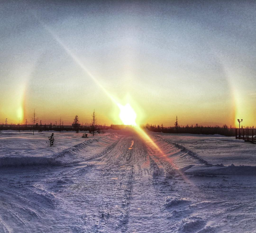

In [22]:
download_validation_image("sun dog")

Obviously this is something completely different!  We didn't train the model on this image, but let's find out how it's categorized.

This is a: loaf of bread
Probability it's a loaf of bread: 0.9573


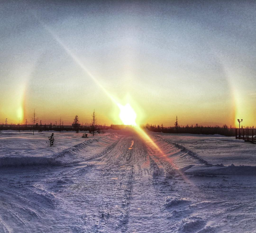

In [23]:
check_category("sun dog")

It is very confident that this is a pig in my test.  How about yours?  (Exact image and training results differ between runs).

What if we train on "sun dog" images?

In [24]:
# larger data set.. does it get better? (answer:yes)
o='sun dog'
dest = (path/o)
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=search_images(f'"{o}" photo', max_images*3)) # do not get 'sun' and 'shade' variants
sleep(10)  # Pause between searches to avoid over-loading server
resize_images(path/o, max_size=400, dest=path/o)

Searching for '"sun dog" photo'


In [25]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [26]:
learn = vision_learner(dls, model, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.004204,4.565392,0.875000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,2.196732,3.644923,0.875000,00:03
1,1.715897,2.438935,0.625000,00:03
2,1.250126,1.760546,0.500000,00:03


This is a: dog
Probability it's a dog: 0.6086


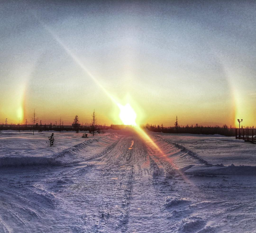

In [27]:
check_category("sun dog")

Did it predict correctly?

# Revision: train more!

Maybe to get the sun dog categorized correctly we just need to train the model for more iterations.  The training loss is not particularly good when adding the sun dog data and only running 3 epochs.  Let's try to fix that!

In [28]:
learn = vision_learner(dls, model, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.237514,2.731876,0.500000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.790769,1.944006,0.500000,00:03
1,1.485760,1.384766,0.500000,00:03
2,1.199894,0.844333,0.500000,00:03
3,0.940816,0.502006,0.375000,00:03
4,0.755119,0.359705,0.125000,00:03
5,0.625443,0.315414,0.125000,00:03
6,0.531597,0.303816,0.125000,00:03
7,0.461811,0.324135,0.125000,00:03
8,0.406859,0.345942,0.125000,00:03
9,0.362687,0.360652,0.125000,00:03


This is a: pig
Probability it's a pig: 0.9900


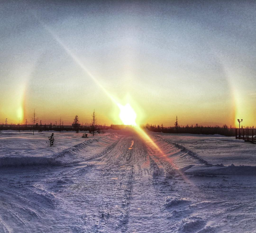

In [29]:
check_category("sun dog")

This didn't help.  But we have a small set of data.  Notice we are using only 15 pictures.  What if we bump this up a good bit?

# Revision: more data!!

Bump the set of data we collect up from 5 per bucket to 30.  Train the model with even more epochs.  Validate

In [30]:
# only more data for dog, pig, and loaf of bread
searches = ['dog','pig','loaf of bread']

max_images = 30

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'"{o}" photo', max_images))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'"{o} in sun" photo', max_images))
    sleep(10)
    download_images(dest, urls=search_images(f'"{o} in shade" photo', max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

o='sun dog'
dest = (path/o)
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=search_images(f'"{o}" photo', max_images*3)) # do not get 'sun' and 'shade' variants
sleep(10)  # Pause between searches to avoid over-loading server
resize_images(path/o, max_size=400, dest=path/o)

Searching for '"dog" photo'
Searching for '"dog in sun" photo'
Searching for '"dog in shade" photo'
Searching for '"pig" photo'
Searching for '"pig in sun" photo'
Searching for '"pig in shade" photo'
Searching for '"loaf of bread" photo'
Searching for '"loaf of bread in sun" photo'
Searching for '"loaf of bread in shade" photo'
Searching for '"sun dog" photo'


In [31]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

In [33]:
learn = vision_learner(dls, model, metrics=error_rate)
learn.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,1.902694,2.396525,0.500000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.845795,1.597569,0.500000,00:08
1,1.533231,1.077993,0.375000,00:08
2,1.268258,0.696869,0.250000,00:08
3,1.082644,0.449434,0.250000,00:08
4,0.888993,0.295587,0.125000,00:08
5,0.752435,0.191547,0.000000,00:08
6,0.649288,0.131499,0.000000,00:08
7,0.564466,0.104856,0.000000,00:08
8,0.497621,0.091254,0.000000,00:08
9,0.453530,0.083963,0.000000,00:08


This is a: dog
Probability it's a dog: 0.4641


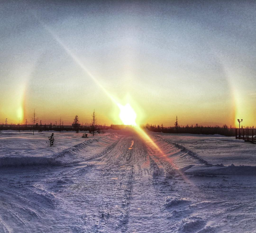

In [34]:
check_category("sun dog")

Was the prediction any better?

We better check the other images..

This is a: dog
Probability it's a dog: 0.7229


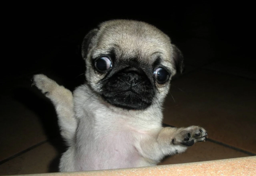

In [35]:
check_category("cute pug face")

This is a: dog
Probability it's a dog: 0.5358


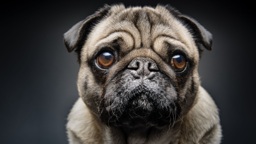

In [36]:
check_category("pug face")

Results may vary depending on the training.  I saw cases where pugs images were classified as pigs and loafs of bread.

The point of this exercies isn't to get a correct result, but to play around with some vison learning models, modifying some parameters and seeing how the results change.  The fact that training the model on a larger data set for a longer period of time (in my example) resulted in a worse prediction is just the icing on the cake.

I hope you learned something and had a fun time.  If you're results are different, amusing, or you tried something else and got an interesting result please let me know.